## Polynomial Regression Challenge

In [1]:
from functions import *
import pandas as pd
import seaborn as sns

Below, we will generate some synthetic data for this challenge

We have 2 continuous features, `x1` and `x2`, and a binary target `y`

In [2]:
data = generate_data(random_seed= 42)
df = pd.DataFrame(data = data, columns = ['x1', 'x2', 'y'])
print(df.shape)
df.head(3)

(1000, 3)


,x1,x2,y
0,-0.597098,0.896927,1.0
1,0.523172,-0.129884,1.0
2,-0.183970,-1.281665,0.0


<AxesSubplot: xlabel='x1', ylabel='x2'>

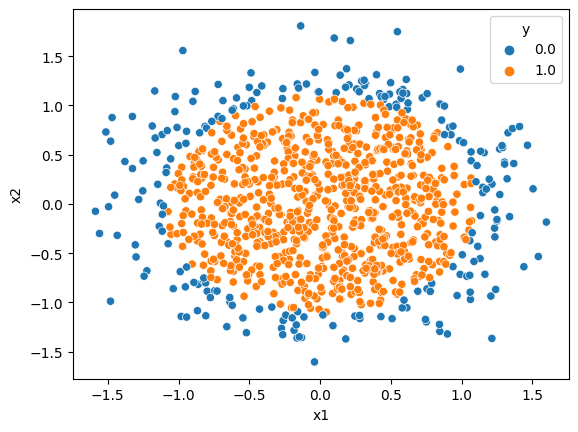

In [3]:
sns.scatterplot(x = df['x1'], y = df['x2'], hue = df['y'])

This is a binary classification problem, so we need to use an appropriate algorithm, like logistic regression. 

Looking at our data, we can see that there does appear to be a clearly defined boundary between the classes (they're not mixed up together).

However, this boundary is clearly not linear, so a basic logistic regression won't work -- we'll need to introduce polynomial features to capture this trend!

>*Note*: There are non-linear models you will encounter soon that could capture this boundary without polynomial features (i.e. a tree based model), but for now we will focus on logistic regression

### Task 1: Data Exploration

We've already looked at the relationship between the features and the target in the visualization above, but lets do some basic QA to ensure our data is suitable for modelling.

1. Look at the descriptive statistics (mean, std dev, quantiles, min, max, etc) for the variables at the target
2. Check if there are any missing values
3. Do some more EDA visualization:
    - Visualize the distribution of each variable (i.e. a histogram for continuous features, a bar plot for the target)
    - Try creating an overlapped histogram of the features to compare their histograms (hint: create two seaborn plots in the same cell, use the `alpha` parameter for transparency)
4. Look at the histograms of x1 and x2
    - Do these look like a familiar distribution? Can you perform a statistical test to check? Assume $\alpha = 0.05$

> Think ahead to your ML modelling:
> Do you think feature scaling is a necessary step here? What is the purpose of feature scaling? Make a decision whether or not to include it in your pipeline
    

#### Descriptive Stats

In [4]:
df.describe()

,x1,x2,y
count,1000.000000,1000.000000,1000.000000
mean,0.021836,0.011643,0.773000
std,0.629175,0.636919,0.419102
min,-1.586814,-1.603269,0.000000
25%,-0.464612,-0.488465,1.000000
50%,0.045429,0.014262,1.000000
75%,0.499372,0.506822,1.000000
max,1.598469,1.806975,1.000000


For x1 and x2, distributions overall appear to be identical, centered around ~0 with a standard deviation of ~0.63

For our target, we observe a class imbalance, with 77.3% 1s. 

#### Nulls

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   y       1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


No Nulls!

#### Plots

<AxesSubplot: xlabel='x1', ylabel='Count'>

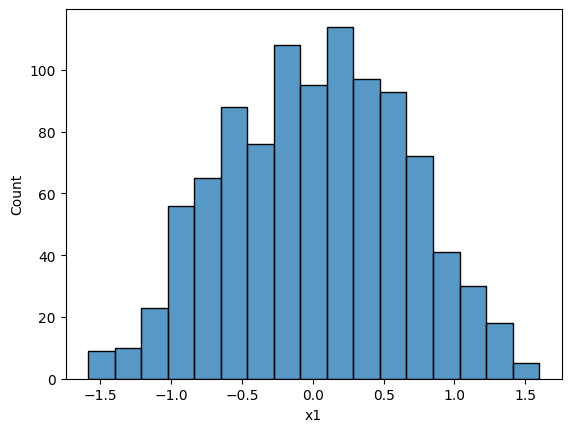

In [6]:
# x1
sns.histplot(data = df, x='x1')

<AxesSubplot: xlabel='x2', ylabel='Count'>

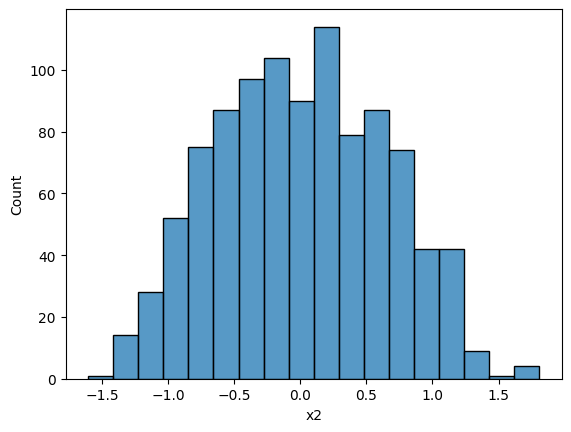

In [7]:
# x2
sns.histplot(data= df, x = 'x2')

<AxesSubplot: xlabel='y', ylabel='count'>

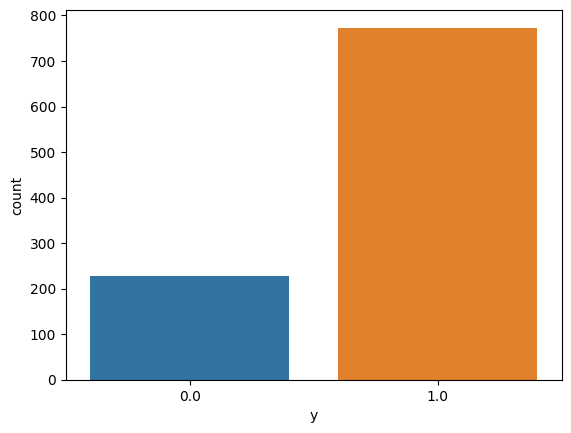

In [8]:
# y
sns.countplot(data = df, x= 'y')

<AxesSubplot: xlabel='x1', ylabel='Count'>

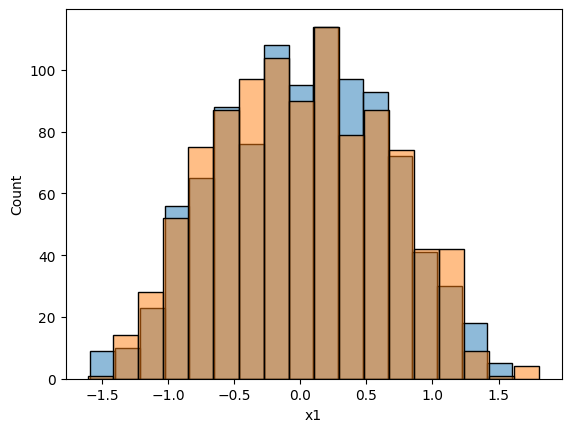

In [9]:
sns.histplot(data = df, x='x1', alpha = 0.5)
sns.histplot(data = df, x= 'x2', alpha = 0.5)

x1 and x2 have very similiar distributions. They also both look possibly normal, lets test that!

#### Distributional Test

In [10]:
from scipy.stats import shapiro

stat1, p1 = shapiro(df['x1'])
stats2, p2 = shapiro(df['x2'])

print('x1: ',round(p1,4))
print('x2: ',round(p2,4))

x1:  0.0
x2:  0.0


Recall that the null hypothesis of the Shapiro Wilkes test is that the data IS normal.

So this data does not meet the rigorous definition of normality. However, we shouldn't throw out our instinct that this data is close to normal - it is still visually bell curved and symmetrical.

#### Feature Scaling?

Recall that one of our primary motivations for performing feature scaling in ML is to ensure all features are of the same magnitude and spread. This prevents larger features from dominating in distance-based models (i.e. k-NN), and allows us to make comparisons between feature importances in our linear models - like our logistic regression we will use here. `x1` and `x2` seem to have the same scale, so we don't really gain much by scaling them.

Also recall that there is a natural 'cost' to performing feature scaling - in that it can distort the original distribution of our features, resulting in a loss of information. However, remember as well that, for StandardScaler, this distortion is smaller for normally distributed variables, and our features, while not statistically normal, do have the visual characteristics of a distribution that would not be distorted by scaling.

Ultimately scaling in this case is up to you, providing a minimal benefit at a minimal cost.

### Task 2: Modelling

1. Perform a train test split on the data 
    - Remember that higher order polynomials will almost always have lower training error due to overfitting
    - We will use evaluation on the test set to decide the best model fit

2. Select an evaluation criterion
    - Our target is imbalanced, is it appropriate to use accuracy?
    - We want an overall good fit, not biased towards false positives or false negatives. Are recall/ precision appropriate?
    - What about one of the 'balanced' criteria for imbalanced data sets?

3. Try a simple logistic regression:
    - We don't expect this to work well, because no straight line can create the correct decision boundary 
    - This will act as our baseline

4. Write a function that computes your chosen metric for different degrees of PolynomialFeatures
    - Inputs should be your dataframes, and the maximum polynomial degree
    - For each degree from 1 to your max degree, fit a logistic regression model
        - (HINT: use `for i in range(1, max+1):`)
    - For each degree, print the degree, and the score for your chosen metric
    - The function should return the fitted model with the highest score

> (STRETCH): There is a more elegant way to do this using sklearn Pipelines, which you will learn later. Optionally, research using pipelines to tune hyperparameters like the degree parameter of PolynomialFeatures. See if you get the same result as your function  

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.1, random_state= 42)

For an evaluation metric we have f1 score - which balances false positive and false negative rates at a prediction probability threshold (i.e. 0.5 by default)

We also have metrics that look at model performance as a whole over the full range of prediction thresholds, like AUC.

Either is fine here, but AUC is a little more rigorous so we'll use that for this solution. 

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lin_model = LogisticRegression()
lin_model.fit(X_train, y_train)

probabilities = lin_model.predict_proba(X_test)[:, 1]  # get probabilities for the 1 class

auc_score = roc_auc_score(y_test, probabilities)
print(f"AUC Score: {auc_score}")

AUC Score: 0.5462499999999999


We can definitely beat this for a function with such well defined boundaries

Your function could look something like this:

In [13]:
def evaluate_regression(X_train, X_test, y_train, y_test, max_degree):
    """"
    A function to determine the best polynomial degree for a logistic regression
    """
    highest_score = 0
    best_model = None
    best_degree = 1  # initialize with the first degree as best
    
    # iterate over degrees of polynomial features
    for degree in range(1, max_degree + 1):
        # poly features
        poly = PolynomialFeatures(degree)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        
        # model fit
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train_poly, y_train)
        
        # predict probas as input to AUC
        probabilities = model.predict_proba(X_test_poly)[:, 1]
        
        # AUC
        auc_score = roc_auc_score(y_test, probabilities)
        print(f"Degree: {degree}, AUC Score: {auc_score}")
        
        # check if this model is the best one so far
        if auc_score > highest_score:
            highest_score = auc_score
            best_model = model
            best_degree = degree
    
    print(f"Best model found at degree {best_degree} with AUC score {highest_score}")
    return best_model, best_degree

In [14]:
model = evaluate_regression(X_train, X_test, y_train, y_test, max_degree= 5)

Degree: 1, AUC Score: 0.5462499999999999
Degree: 2, AUC Score: 1.0
Degree: 3, AUC Score: 1.0
Degree: 4, AUC Score: 1.0
Degree: 5, AUC Score: 1.0
Best model found at degree 2 with AUC score 1.0


Looks like we get a 'perfect' model at degree 2. Do we need to go higher than that? Probably not

### Task 3: Interpretation

We have created a function for you to visualize the decision boundary created by your model. We already imported it at the top of this notebook.

The function call looks like `plot_boundaries(X, y, degree)`, where X is your features dataframe (i.e. X_train), your target series (i.e. y_train), and degree is the integer of the maximum polynomial degree

1. Experiment with this function with different polynomial degrees
    - What is the smallest degree that seems to effectively capture the decision boundary?
    - Does this match with your findings from the modelling step?

2. Look up the mathematical function to define a circle - we can consider this the underlying 'data generating function'
    - Is this the same degree as your best model fit?
    - Consider, in general, does it make sense to use a higher order polynomial than that which captures the actual physical process?

You will find that we get a visually perfect model at degree = 2. This makes sense because the equation for a circle (centered on the origin) is $x^2 + y^2 = r^2$, where $r$ is the radius. So a circular decision boundary can mathematically be captured by degree 2 of our two features. 

While we could use a model with higher degree features, it doesn't make sense to do so - we should strive to use the simplest model that still effectively captures our patterns to prevent overfitting.

/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


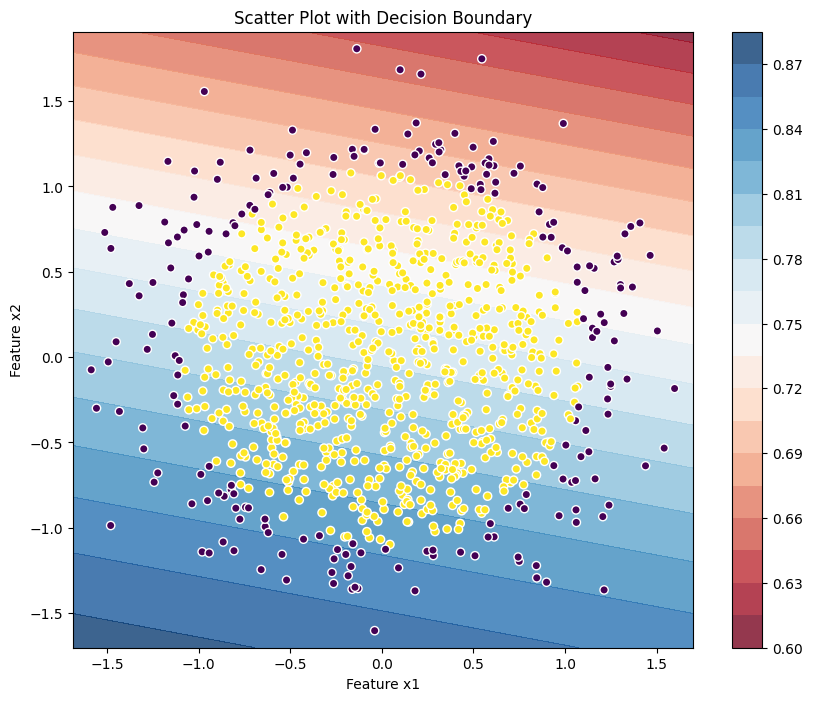

In [15]:
plot_boundaries(X,y, 1) # 1 degree, pretty bad

/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


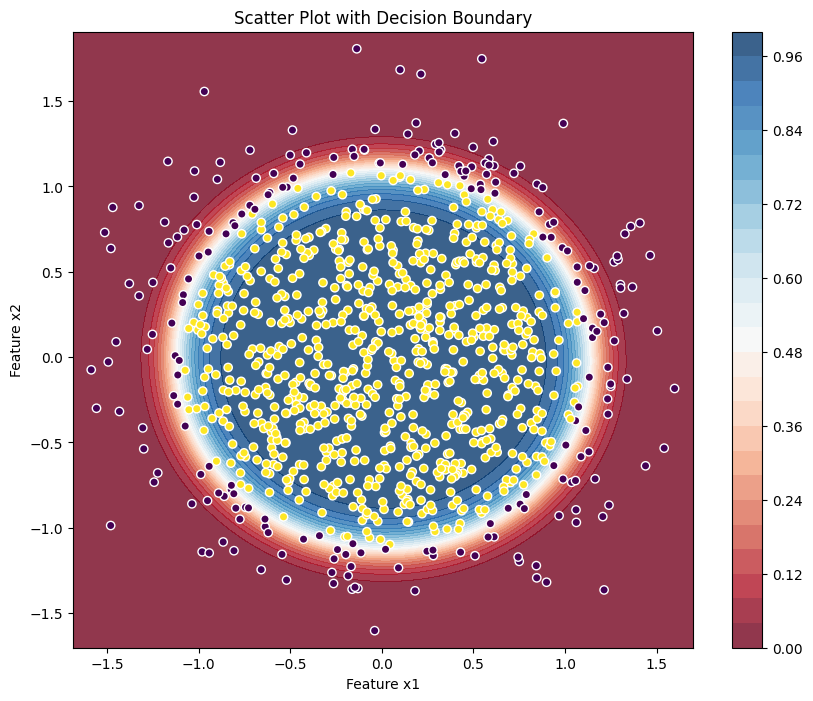

In [16]:
plot_boundaries(X,y, 2) # 2 degrees, perfect

/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


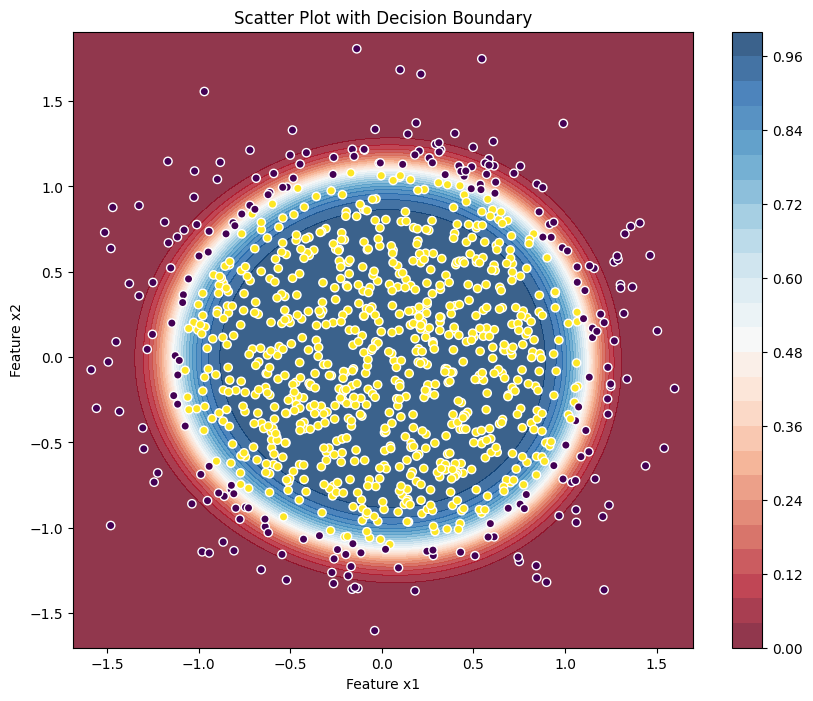

In [17]:
plot_boundaries(X,y, 3) # 3 degrees, same as 2

### Task 4: The Right Tool for the Job

Some models naturally do a better job at some tasks than others. Once we are familiar with more models, we can use our intuition as data scientists to choose the right tool for the job. 

k-Nearest Neighbors Classifier is a very simple model that considers the `k` closest examples to the prediction target in the feature space (by euclidean distance), and takes the 'vote' of these neighboring examples to make a prediction. So if 3 neighbors were class 1 and 2 were class 0, we would predict class 1 (with a probability of $\frac{3}{5}$)

(Note: k-NN can also be a regressor, where the values of the neighboring examples are simply averaged)

Unlike logisitic regression, k-NN does not model any particular mathematical function. It is a [non-parametric model](https://en.wikipedia.org/wiki/Nonparametric_statistics#:~:text=Non%2Dparametric%20models%20differ%20from,and%20not%20fixed%20in%20advance.) without a specified structure, and so can potentially fit complex decision boundaries, despite its simplicity. 

1. Try using our previous plotting function with the added argument `modeltype = 'knn'`. This model is much simpler than engineering polynomial features - does it still capture our decision boundary effectively?

> Note: If you want to investigate more with k-NN there is a `neighbors` argument in the function. By default it is set to 1.


Looks like this very very simple model has also captured our decision boundary reasonably well! There is no probability gradient with k = 1, but if you fiddle with the k argument you'll see a gradient develop similar to 

/opt/miniconda3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


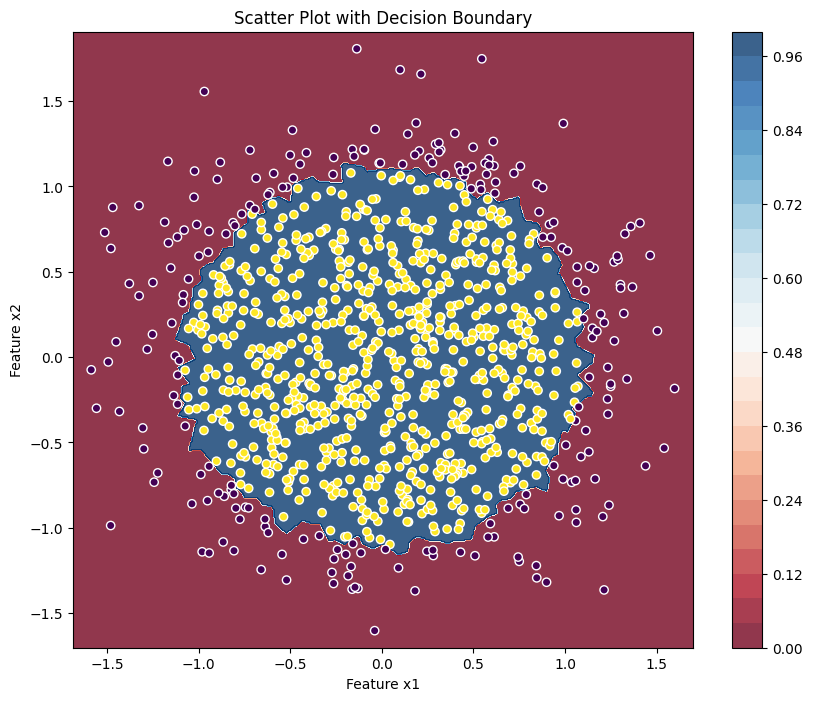

In [18]:
plot_boundaries(X,y, modeltype= 'knn')